In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device: ", device)

# number of batches to be processed
batch_size = 64
#step size of weight updates
learning_rate = 0.001
# number of times to see the entire dataset
num_epochs = 5

Using Device:  cpu


In [3]:
# download the data and convert to tenser then normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

# create dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]

Training samples: 60000
Test samples: 10000


In [4]:
# cnn architecture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128,10)
        self.dropout = nn.Dropout(0.5)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        #pipeline
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model = CNN().to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

Total parameters: 421,642


In [5]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
# training the data
def train(model, device, optimizer, train_loader, epoch, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output,target)

        loss.backward()
        optimizer.step()

        running_loss +=loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if (batch_idx+1)%100 ==0:
            print(f"Epoch: {epoch/num_epochs}, Step: {batch_idx+1/len(train_loader)}, Loss: {loss.item():.4f}")

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100 * correct/total
    return epoch_loss, epoch_acc

In [7]:
# testing data
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data,target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output,target)

            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total +=target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct/total
    print(f"Test Loass: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")
    return test_loss, test_acc

In [8]:
#training the model
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, optimizer, train_loader, epoch,criterion)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch} Summary - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch: 0.0, Step: 99.00106609808103, Loss: 0.2423
Epoch: 0.0, Step: 199.00106609808103, Loss: 0.1843
Epoch: 0.0, Step: 299.001066098081, Loss: 0.1927
Epoch: 0.0, Step: 399.001066098081, Loss: 0.3462
Epoch: 0.0, Step: 499.001066098081, Loss: 0.1167
Epoch: 0.0, Step: 599.001066098081, Loss: 0.2464
Epoch: 0.0, Step: 699.001066098081, Loss: 0.0844
Epoch: 0.0, Step: 799.001066098081, Loss: 0.0673
Epoch: 0.0, Step: 899.001066098081, Loss: 0.0422
Test Loass: 0.0485, Test Accuracy: 98.41
Epoch 0 Summary - Train Loss: 0.2052, Train Acc: 93.77%, Test Loss: 0.0485, Test Acc: 98.41%
Epoch: 0.2, Step: 99.00106609808103, Loss: 0.0811
Epoch: 0.2, Step: 199.00106609808103, Loss: 0.1802
Epoch: 0.2, Step: 299.001066098081, Loss: 0.1270
Epoch: 0.2, Step: 399.001066098081, Loss: 0.0097
Epoch: 0.2, Step: 499.001066098081, Loss: 0.0640
Epoch: 0.2, Step: 599.001066098081, Loss: 0.1140
Epoch: 0.2, Step: 699.001066098081, Loss: 0.1853
Epoch: 0.2, Step: 799.001066098081, Loss: 0.0278
Epoch: 0.2, Step: 899.00106

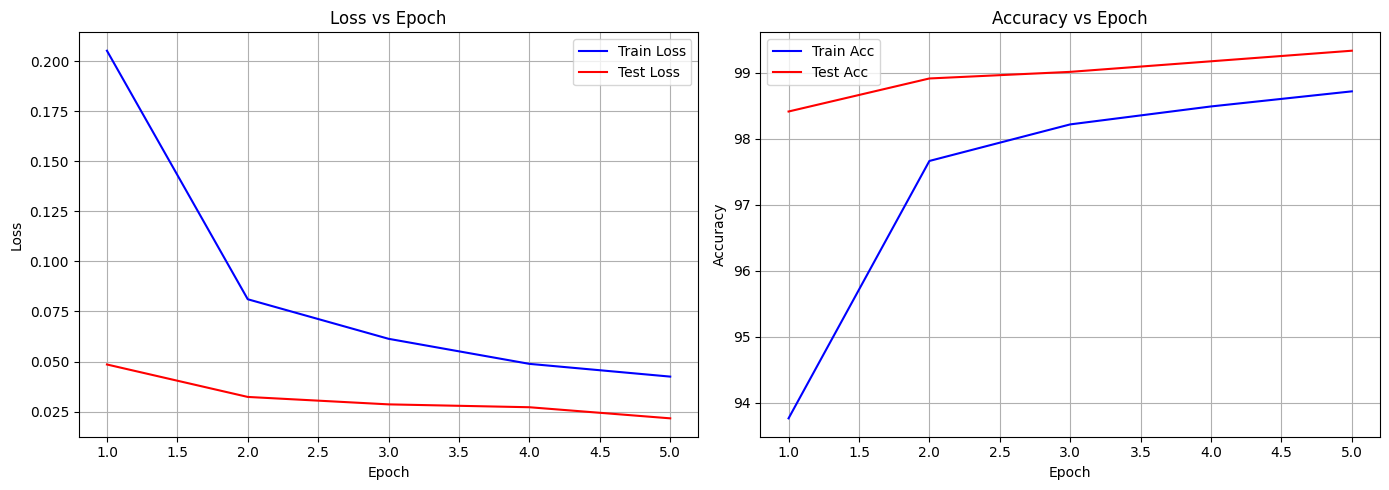

In [9]:
# plotting the accuracy and loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.plot(range(1, num_epochs +1), train_losses, 'b-', label="Train Loss")
ax1.plot(range(1, num_epochs+1), test_losses, 'r-', label="Test Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss vs Epoch')
ax1.grid(True)

ax2.plot(range(1, num_epochs +1), train_accs, 'b-', label="Train Acc")
ax2.plot(range(1, num_epochs+1), test_accs, 'r-', label="Test Acc")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Accuracy vs Epoch')
ax2.grid(True)

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

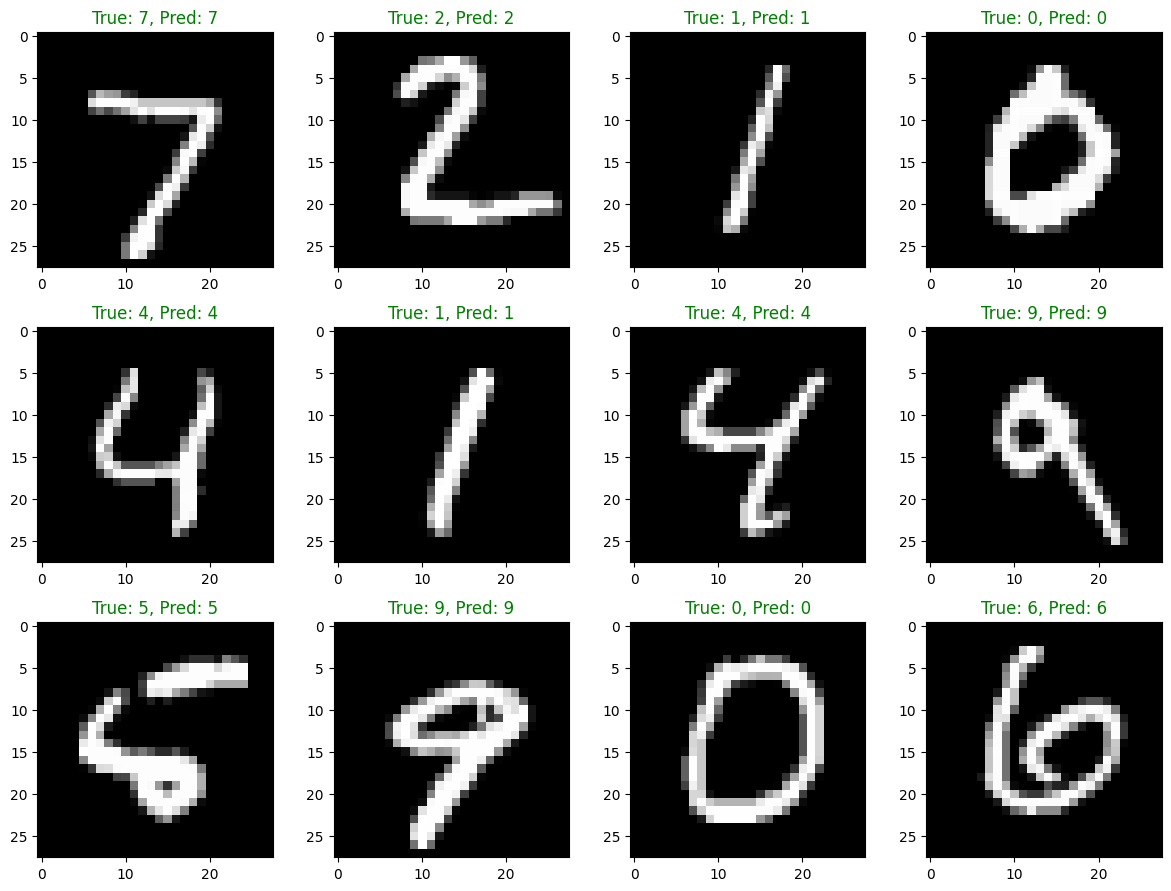

In [10]:
model.eval()
test_examples = iter(test_loader)
test_data, test_targets = next(test_examples)
test_data = test_data.to(device)

with torch.no_grad():
    outputs = model(test_data)
    _,predictions = torch.max(outputs, 1)

fig, axs = plt.subplots(3,4, figsize=(12,9))
for i,ax in enumerate(axs.flat):
    img = test_data[i].cpu().squeeze()
    true_label = test_targets[i].item()
    pred_label = predictions[i].item()

    ax.imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)

plt.tight_layout()
plt.show